In [1]:
#Fresh Cortex from Adult Mouse Brain (P50) - Epi ATAC v.10 - fresh
 

In [2]:
#install packages
# !pip install pandas
# !pip install scipy
# !pip install pyfaidx
# !pip install scikit-learn
# !pip install scanpy 
# !pip install anndata
# !pip install igraph
# !pip install leidenalg

import sys
import anndata
import tensorflow as tf
import matplotlib.pyplot as plt
print(sys.executable)


/opt/anaconda3/envs/VIB_model/bin/python


In [3]:
import pandas as pd
from scipy.io import mmread
from scipy.sparse import csr_matrix
import numpy as np 

#load matrix - counts (peak,cell) --> (n_peaks,num_cells)
matrix = mmread("filtered_peak_bc_matrix/matrix.mtx").tocsc()
#print(matrix[1:2]) #coords (row-index-peak, col-index-cell_, value = how many time accessible)
#load peaks - (n_peaks, 3 - chr,start,end)
peaks = pd.read_csv("filtered_peak_bc_matrix/peaks.bed", sep = "\t", header = None)
#Load cell barcodes --> (n_cell, 1)
barcodes = pd.read_csv("filtered_peak_bc_matrix/barcodes.tsv", header = None)
#assign rows and cols
peaks.columns = ["chr", "start", "end"]
barcodes.columns = ["cell_barcode"]


In [4]:
#binarize accessibility matrix (1=open, 0=closed)
matrix_binary = (matrix>0).astype(int)
#Compute number of cells with each peak accessible -sum across cells
peak_accessibility = np.array(matrix_binary.sum(axis=1)).flatten()
print(matrix_binary[:5, :10].toarray())

print(peak_accessibility)

[[0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]]
[260 731  86 ... 453 407  61]


In [5]:
"""Structure of AnnData object:
    adata.X --> main data matrix --> (cells x features) --> example: accessibility or gene expression
    adata.obs --> cell level metadata (1D)  --> (cells x metada columns) --> example: cell barcode, sluter, QC metrics
    adata.var--> feature level metadata matrix --> (features x metadata columns) --> example: peak coordinates, feature accessbility 
    adata.obsm --> cell-level multi-dimensional arrays -->  (cells x k) --> example: PCA, LSI, UMAP embeddings etc..
    adata.varm --> feature-level multi-dimensional arrays -->  (features x k) --> example: gene loadings, LSI, peak loadings 
    
    ALSO; not included here, 
    adata.obsp and adata.varp --> cell x cell , feature x feature, pairiwse relationship
    """



'Structure of AnnData object:\n    adata.X --> main data matrix --> (cells x features) --> example: accessibility or gene expression\n    adata.obs --> cell level metadata (1D)  --> (cells x metada columns) --> example: cell barcode, sluter, QC metrics\n    adata.var--> feature level metadata matrix --> (features x metadata columns) --> example: peak coordinates, feature accessbility \n    adata.obsm --> cell-level multi-dimensional arrays -->  (cells x k) --> example: PCA, LSI, UMAP embeddings etc..\n    adata.varm --> feature-level multi-dimensional arrays -->  (features x k) --> example: gene loadings, LSI, peak loadings \n\n    ALSO; not included here, \n    adata.obsp and adata.varp --> cell x cell , feature x feature, pairiwse relationship\n    '

In [6]:
#Perform Pre-processing with Scanpy
matrix_Transposed = matrix_binary.T # trasnpose the matrix so it is cells x peaks - Scanpy expect that 
#assign barcodes columns

#create AnnData object (Scanpy's main data structure)
#adata,X cords (row_idx = cell idx, col_idx = peak_idx)  value 1 or 0
adata = anndata.AnnData(X = matrix_Transposed)
#rows , peaks.... each row return a sparse matrix for each cell
#(5K cells , 157K peaks)
print(adata.X.shape)
#Check the Compressed Row sparse matrix  (working with rows-cells)--> SAVE. MOEMORY c
#coords --> row, col_idex --> e.g (0,1) cell 0, has accessible peak 1, here vlues=1 as it is binarized
#print(adata.X)

#Data frame n_cells x n_cell_meatada_cols
adata.obs_names = barcodes['cell_barcode'].values #cell meatadata live in adata.obs 


#Sum across cellls --> how many cells show this peak acessibile -  into feature metadata(variables)
#Add to var bcs var  describes peaks  -col of X
adata.var["peaks_accessibility"] = peak_accessibility #peak metadata live in adata.var

#Sum over how mean peaks are open in each cell
#Store it to observation, bcs cell belong to obs
adata.obs["Peaks_per_cell"] = np.array(matrix_binary.sum(axis=0)).flatten()

#Each peak is a featurure (one col in matrix)
#Each peaks corresponds ot one entyr in the var_names
#Give var_names --> peak genomics coordinated (columns=peaks/features)
adata.var_names = peaks.apply(lambda x: f"{x['chr']}:{x['start']}-{x['end']}", axis=1)
adata.var["chr"] = peaks["chr"].values
adata.var["start"] = peaks["start"].values
adata.var["end"] = peaks["end"].values

print("Peaks level metadata for first 5 peaks", "\n" ,adata.var.head() , "\n")

print("Cell level metadata", "\n")
print(adata.obs.head())

print("Genomic coordinates for first 5 peaks", adata.var_names[:5])#genomic coordinates of first 5 peaks 
print("First 5 barcodes", adata.obs_names[:5])



(5337, 157797)
Peaks level metadata for first 5 peaks 
                       peaks_accessibility   chr    start      end
chr1:3094708-3095552                  260  chr1  3094708  3095552
chr1:3119414-3121782                  731  chr1  3119414  3121782
chr1:3204809-3205178                   86  chr1  3204809  3205178
chr1:3217330-3217359                   12  chr1  3217330  3217359
chr1:3228123-3228463                   81  chr1  3228123  3228463 

Cell level metadata 

                    Peaks_per_cell
AAACGAAAGTAATCAG-1           32050
AAACGAACACGCTGTG-1           10522
AAACGAATCCTGGGAC-1           14771
AAACGAATCGGGAAAC-1           13677
AAACTCGAGAAAGCAG-1           20373
Genomic coordinates for first 5 peaks Index(['chr1:3094708-3095552', 'chr1:3119414-3121782', 'chr1:3204809-3205178',
       'chr1:3217330-3217359', 'chr1:3228123-3228463'],
      dtype='object')
First 5 barcodes Index(['AAACGAAAGTAATCAG-1', 'AAACGAACACGCTGTG-1', 'AAACGAATCCTGGGAC-1',
       'AAACGAATCGGGAAAC-1', 

In [7]:
#count the number of zeros in the sparse matrix
total_entries = adata.X.shape[0] * adata.X.shape[1] #cells x peaks
nonzero_entries = adata.X.count_nonzero() #count non zero in th sparse matrix
sparsity =  100 * (1 - nonzero_entries/total_entries) #fraction of zeros

print(f"sparsity: {sparsity: .2f}% of the matrix is 0")

sparsity:  94.42% of the matrix is 0


In [8]:
from sklearn.feature_extraction.text import TfidfTransformer

#Step 2: perform TermFrequency(TF) -InverseDocumentFrequency(IDF) normalization
"""Explanation Tf, IDF, Tf-IDF
    NLP comparison --> term = peak, document = cell, 
    #TF = how mamny times a word appear in a book
    #IDF = how many books in library cntain that term

    #Tf(j) = accessibility peak j in cell i/total accessible peaks in cell i,
    #IDF(j)=log((1 + N(cells) / 1 + nj (number of cells with peak j accessible-frequence)) 
    #TF-D= Tf x idf, sparse matrix preserved --> TF weighed measure of peak acessibility emphasizing rare but specific signals."""
tf_idf = TfidfTransformer()
#fit = calculate IDF for each peak, transofrm = applied both Tf and IDf to matrix
X_tfidf = tf_idf.fit_transform(adata.X)


#update anndata with normalized data 
#now the values are weighted accessibility scores, higher value = peak specifically accessible in given cell, lower val = peak is common across cells
adata.X = X_tfidf

"""A peak appear in all cells --> is low informaitve --> so it receives low weight - peaks are everywhere
    Peaks accessible in specific cells get high weight --> means specific to certain cells types"""


'A peak appear in all cells --> is low informaitve --> so it receives low weight - peaks are everywhere\n    Peaks accessible in specific cells get high weight --> means specific to certain cells types'

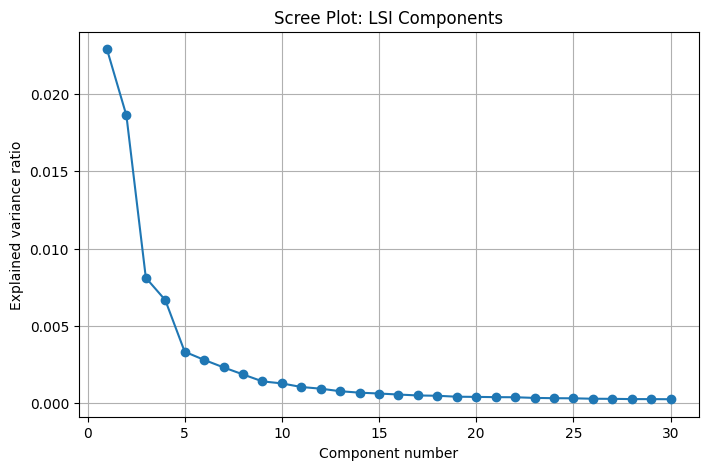

'In this data, 20 components - dims, are enough to capture major chr.access patterns, each new compoent adds tiny amount of variance'

In [9]:
#Step 3: perform Dim. Rduction via LSI --> T

from sklearn.decomposition import TruncatedSVD
#num_cp,[pemts ,  how many latent dimensions (to compute, how many summary axes to use to describe the 157K dimensional space(each peak=one dim)
svd = TruncatedSVD(n_components=30, random_state=42) #many sc-atc - seq,  uusually utilizes  30-100 components.Random state for reproducability
#analyse data to learn  PC, and projecct the high dimd ata to lower dim space spanneds by these PC.
X_lsi = svd.fit_transform(adata.X)

#store as PCA embedding
adata.obsm["X_lsi"] = X_lsi

explained_var = svd.explained_variance_ratio_

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_var)+1), explained_var, marker='o')
plt.xlabel("Component number")
plt.ylabel("Explained variance ratio")
plt.title("Scree Plot: LSI Components")
plt.grid(True)
plt.show()


"""In this data, 20 components - dims, are enough to capture major chr.access patterns, each new compoent adds tiny amount of variance"""


In [10]:
#Step4: neighbors and clustering
import scanpy

#Build nearest neighbors graphs oc cells in  LSI dimension space
scanpy.pp.neighbors(adata, use_rep="X_lsi", n_neighbors=20)
#Project LSI structure into 2D space for visualization
scanpy.tl.umap(adata) 
#output adata.obsm[X_umap"]
print(adata.obsm["X_umap"])


#Perform Leiden clustering on the neighbor graph. --> ccluster cells into groups
#Stores the communities of cells --> one cluster label per cell --> output adata.obs["leiden"]
scanpy.tl.leiden(adata, resolution=0.5) # clusters cell sinto subgroups



/opt/anaconda3/envs/VIB_model/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[[-4.157295   10.838663  ]
 [-6.8761163   2.6879497 ]
 [-2.1096997   9.593538  ]
 ...
 [-0.46231169 -1.8079295 ]
 [-4.7034235   7.727404  ]
 [11.961421    8.4336815 ]]


/var/folders/qs/800v22r160x4jpwz94lztymw0000gn/T/ipykernel_2350/3356919497.py:14: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  scanpy.tl.leiden(adata, resolution=0.5) # clusters cell sinto subgroups


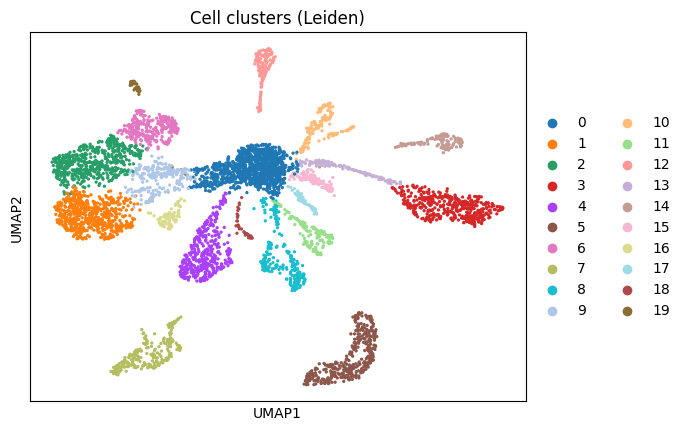

20


In [11]:
#Step 5: Combine UMAP and Leiden for visualization 
scanpy.pl.umap(adata, color = "leiden", title = "Cell clusters (Leiden)")


#get unique num of clusters
clusters = adata.obs["leiden"]
num_clusters = clusters.nunique()
print(num_clusters)

In [12]:
from pyfaidx import Fasta
#load genome  Fasta file
genome = Fasta("Genomes/Mus_musculus.GRCm39.dna.primary_assembly.fa")

#replace chr as str name because in genome there is only number
peaks['chr'] = peaks['chr'].str.replace('chr',"")
#function to get sequence
def get_sequence(row):
    return genome[row['chr']][row['start']:row['end']].seq

peaks['sequence'] = peaks.apply(get_sequence, axis=1) #aply the funcition getsequences


In [13]:
#Pad if seq < 150nt or trim it if is is larger
def pad_or_trim(seq, window_size = 150):
    seq = seq.upper()
    if len(seq) > window_size:
        return seq[:window_size]
    return seq + "N" * (window_size - len(seq)) #Pad with Ns


#Create one hot encoding function for the sequence
def one_hot_encoding(sequence):
    mapping = {"A":0, "C":1, "G":2, "T":3}
    one_hot = np.zeros((len(sequence), 4), dtype = np.int8) #rows-len of seq, and cols 4 possible nts
    for i, nt in enumerate(sequence.upper()):
        if nt in mapping:
            one_hot[i, mapping[nt]] = 1
    return one_hot


#add trimmed seq in the peaks 
peaks['trimmed_sequence'] = peaks['sequence'].apply(pad_or_trim)

#for all seqs
encoded_sequences = [one_hot_encoding(seq) for seq in peaks['trimmed_sequence']]



In [87]:
#Stratified sampling 
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

#Subsample peaks and cells, because 5K cells pairing with  197K peaks, leads to explosion s
n_peaks = 5000
n_cells = 1000

#Get cluster labels for all cells, aligned with barcode order, use adata obejct
cell_clusters = adata.obs["leiden"].loc[barcodes["cell_barcode"].values].values # get barcodes, and extract leiden values listed in barcodes 


#Stratified sampling to select balance subset of cells based on cluster labels
sss = StratifiedShuffleSplit(n_splits = 1, test_size = n_cells, random_state= 42)

#sss.split(X,y - x = features, y= class labels= cell_clusters
_, selected_cell_idx = next(sss.split(np.zeros(len(cell_clusters)), cell_clusters))
selected_cells_barcodes = barcodes["cell_barcode"].values[selected_cell_idx]

#Select most accessible peaks --> how many cells each peak is accessible--> pic the top 5K , NOTE we use original matrix
peak_sums = np.array(matrix_binary.sum(axis=1)).flatten()  # total accessibility per peak

\top_peak_indices = peak_sums.argsort()[-n_peaks:] #argsort returns the indices that would sort array ia scending
selected_peaks = peaks.index.values[top_peak_indices]

#subset the binary matrix based on top peaks and selected_cell indices
matrix_sub = matrix_binary[selected_peaks, :][:, selected_cell_idx]
#Convert submatrix to dense for indexing
mat_dense = matrix_sub.toarray()
#2D array , rows = peaks, cols = cells
print(mat_dense.shape)


#Prepate cell clucter input --> get lediden cluster of each selcted sell and on hot encode it
cell_clusters_sub = adata.obs.loc[selected_cells_barcodes, 'leiden'].values.reshape(-1, 1)

#encodes categoical variacbles -cell cluster into one hot vectors  
#this is empty object that will later be used to encode cluster labels
enc = OneHotEncoder(sparse_output=False)
#A 1-hot encoding for each cell's cluster indetity (one per cell)
X_cell_onehot = enc.fit_transform(cell_clusters_sub)  # shape (n_cells, num_clusters)

['6', '1', '6', '7', '1', ..., '0', '0', '4', '2', '14']
Length: 5337
Categories (20, object): ['0', '1', '2', '3', ..., '16', '17', '18', '19']
['6', '1', '6', '7', '1', ..., '0', '0', '4', '2', '14']
Length: 5337
Categories (20, object): ['0', '1', '2', '3', ..., '16', '17', '18', '19']
[  9667  81994 141887]
(5000, 1000)


In [15]:
"""To train the model we have:
    -mat dense --> 2D array, rows=peaks, cols = cells, entry accessible or not fo that cll
    -encoed seuqnces --> alist of 1 oht encoed DNa seqs (one per peak))
    - C_cell_onehot --> ont hot encoding for eahc cell cluster identity)"""

#Now Find all positve and negative examples -coordinates,
#argwhere reutnrs row and ocl indices for peak in rows and cell in cols
pos_idx = np.argwhere(mat_dense == 1)
neg_idx = np.argwhere(mat_dense == 0) #where inaccess peaks are=0

np.random.seed(42)
n_pos = len(pos_idx)
neg_sample = neg_idx[np.random.choice(len(neg_idx), size = n_pos, replace = False)]
print(neg_sample) #example: 1s row: 3829 peak number 1510, in cell 826 is inaccessible -

#Combine and shiffle --> dL model wants a single data et, both posite and negative exmaples mixed
#stack the arrays one of top t th eother
pairs = np.vstack([pos_idx, neg_sample])
np.random.shuffle(pairs)# randomize order

#get the all rows, and take only 1st col -peaks
peak_idx = pairs[:, 0]
#get the all rows, and take only 1st col -peaks
cell_idx = pairs[:, 1]

#Seq input for selected peaks
X_seq_sub = np.stack([encoded_sequences[i] for i in selected_peaks[peak_idx]])
print(selected_peaks[peak_idx])

#Cell type cluster one hot 
X_cell_sub = X_cell_onehot[cell_idx]

#labels 
y_sub = mat_dense[peak_idx, cell_idx].astype(np.int8)


#Split into train / test
#X_seq_sub =, dna seq of a peak, X_cell_sub = cluster idenity, y_sub =0 or 1
X_seq_train, X_seq_test, X_cell_train, X_cell_test, y_train, y_test = train_test_split(
    X_seq_sub, X_cell_sub, y_sub, test_size=0.2, random_state=42
)

[[2614  941]
 [2919  928]
 [ 662  231]
 ...
 [3232    4]
 [3618  561]
 [2076   11]]
[133163   3280  93093 ... 153916 100012 137314]


In [89]:
from sklearn.utils import resample
#usapmling positive class
#sploit data into majority and minority class
X_seq_train_majority = X_seq_train[y_train == 0]
X_seq_train_minority = X_seq_train[y_train == 1]

#
X_cell_train_majority = X_cell_train[y_train == 0]
X_cell_train_minority = X_cell_train[y_train == 1]

y_train_majority = y_train[y_train == 0]
y_train_minority = y_train[y_train == 1]

# Upsample minority indices
#E.g we have 8000 majority, and 2000 for minority
#finds the length of minority
idx_minority = np.arange(len(y_train_minority))
##Randomly seleect 8k indeices fom the minority class - repetion allowed
idx_upsampled = resample(
    idx_minority,
    replace = True,
    n_samples = len(y_train_majority),
    random_state = 42
)

X_seq_minority_upsampled = X_seq_train_minority[idx_upsampled]
X_cell_minority_upsampled = X_cell_train_minority[idx_upsampled]
y_minority_upsampled = y_train_minority[idx_upsampled]

# Combine majority and upsampled minority
X_seq_train_balanced = np.concatenate([X_seq_train_majority, X_seq_minority_upsampled])
X_cell_train_balanced = np.concatenate([X_cell_train_majority, X_cell_minority_upsampled])
y_train_balanced = np.concatenate([y_train_majority, y_minority_upsampled])


#random ordering (not all 0 first, and then 1s)
perm = np.random.permutation(len(y_train_balanced))
# X_seq_train_balanced = X_seq_train_balanced[perm[
# X_cell_train_balanced = X_cell_train_balanced[perm] 


In [90]:
from collections import Counter
print(Counter(y_sub)) 
print(Counter(y_train))
print(Counter(y_train_balanced))

Counter({0: 1778372, 1: 1778372})
Counter({1: 1423610, 0: 1421785})
Counter({0: 1421785, 1: 1421785})


In [91]:
#GPU through metal, much faster than GPU only
#!pip install tensorflow-macos tensorflow-metal

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

In [133]:
#Use multi task with DNA sequence and cell type from cluster as input
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, Concatenate, BatchNormalization, Activation
from tensorflow.keras import  metrics
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


seq_input = Input(shape=(150,4), name = "sequence_input")

#Sequentioal CNN blocks --> dont capture different motif lengths
#CNN block 1 on DNA
# x = Conv1D(filters = 32,kernel_size = 8, padding = "same", use_bias = False)(seq_input)
# x = BatchNormalization()(x)
# x = Activation("relu")(x)

# #CNN block 2 on DNA
# x = Conv1D(filters = 64, kernel_size =  4, padding = "same" , use_bias = False)(x)
# x = BatchNormalization()(x)
# x = Activation("relu")(x)


#try to use different kernel size to capture motifs with different length
#TF binding sites are usualy 5-20 bp long 
#filter--> different convolution filters (outpu) 00> 32 diferent motif detectors, each can learn different pattern
conv3 = Conv1D(filters = 32, kernel_size = 6, padding="same")(seq_input) # kernel_size =12-len of each filter-how many nt learning
conv5 = Conv1D(32, 10, padding= "same")(seq_input)
conv8 = Conv1D(32, 18, padding= "same")(seq_input)

x = Concatenate()([conv3,conv5, conv8])
x = BatchNormalization()(x)
x = Activation("relu")(x)

#Deeper CNN to capture motif interactions
x = Conv1D(128, 5, padding= "same", activation="relu", kernel_regularizer= l2(1e-5))(x)
x = GlobalMaxPooling1D()(x)
x = Dropout(0.5)(x)


#input cell type z
cell_type_input = Input(shape = (20,), name = "cell_type_input") # number of cell clusters from above



#Concatenate features
combined = Concatenate()([x,cell_type_input])
combined = Dense(64, use_bias = False,  kernel_regularizer=l2(1e-5))(combined)#L2 regularization to prevent overfitting
combined = BatchNormalization()(combined)
combined = Activation("relu")(combined)
combined = Dropout(0.3)(combined)


output = Dense(1, activation = "sigmoid", name = "accessibility")(combined)

#build model
model = Model(inputs=[seq_input, cell_type_input], outputs = output)
#use adam optimizer with lower learing rate
optimizer = Adam(learning_rate = 1e-4) #default is 0.001 (1e-4)

metrics = [
    "accuracy",
    metrics.AUC(name="auc"),
    metrics.Precision(name = "precision"),
    metrics.Recall(name = "recall"),

]

#Include early stopping, because we have high overfitting (accuracy at 50% and val acucracy to 36%
early_stopping = EarlyStopping(monitor = "val_auc",
                               patience = 5,
                               mode = "max",
                               restore_best_weights = True)

#Lower Learning rate if stuck
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr = 1e-6
)

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_balanced),
    y=y_train_balanced
)
class_weights = dict(enumerate(class_weights))


model.compile(
    optimizer = optimizer,
    loss="binary_crossentropy",
    metrics=metrics
)

#fit model
history = model.fit(
    [X_seq_train_balanced, X_cell_train_balanced], 
    y_train_balanced,
    validation_data=([X_seq_test, X_cell_test], y_test),
    epochs=20,#low epochs due to running time 
    batch_size=128,
    callbacks = [early_stopping, reduce_lr],
    class_weight=class_weights
)

Epoch 1/20
22216/22216 ━━━━━━━━━━━━━━━━━━━━ 577s 26ms/step - accuracy: 0.6697 - auc: 0.7183 - loss: 0.5938 - precision: 0.6332 - recall: 0.7986 - val_accuracy: 0.7209 - val_auc: 0.7754 - val_loss: 0.5319 - val_precision: 0.6606 - val_recall: 0.9058 - learning_rate: 1.0000e-04
Epoch 2/20
22216/22216 ━━━━━━━━━━━━━━━━━━━━ 549s 25ms/step - accuracy: 0.7211 - auc: 0.7732 - loss: 0.5340 - precision: 0.6598 - recall: 0.9134 - val_accuracy: 0.7215 - val_auc: 0.7808 - val_loss: 0.5290 - val_precision: 0.6582 - val_recall: 0.9188 - learning_rate: 1.0000e-04
Epoch 3/20
22216/22216 ━━━━━━━━━━━━━━━━━━━━ 542s 24ms/step - accuracy: 0.7213 - auc: 0.7770 - loss: 0.5319 - precision: 0.6602 - recall: 0.9113 - val_accuracy: 0.7224 - val_auc: 0.7846 - val_loss: 0.5268 - val_precision: 0.6609 - val_recall: 0.9108 - learning_rate: 1.0000e-04
Epoch 4/20
22216/22216 ━━━━━━━━━━━━━━━━━━━━ 555s 25ms/step - accuracy: 0.7226 - auc: 0.7805 - loss: 0.5300 - precision: 0.6631 - recall: 0.9058 - val_accuracy: 0.7230 - 

In [135]:
pd.DataFrame(history.history).to_csv("training_history.csv", index=False)

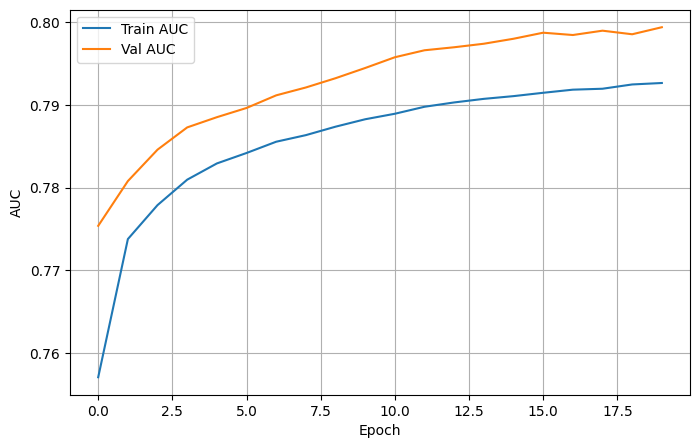

In [157]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history["auc"], label = "Train AUC")
plt.plot(history.history["val_auc"], label = "Val AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()
plt.grid()

In [179]:
from sklearn.metrics import classification_report, roc_auc_score
#Evaluate on test set
y_pred = (model.predict([X_seq_test, X_cell_test]) > 0.5).astype(int)

print(classification_report(y_test, y_pred))



22230/22230 ━━━━━━━━━━━━━━━━━━━━ 54s 2ms/step
              precision    recall  f1-score   support

           0       0.85      0.57      0.68    356587
           1       0.67      0.90      0.77    354762

    accuracy                           0.73    711349
   macro avg       0.76      0.73      0.72    711349
weighted avg       0.76      0.73      0.72    711349



In [165]:
print('TEST AUC', roc_auc_score(y_test, y_pred))

TEST AUC 0.732502525306425


In [175]:
# get weights of the first convolution layer
conv_layer = model.get_layer("conv1d_61") 
filters, biases = conv_layer.get_weights()
print(filters)  # e.g., (kernel_size, 4, n_filters)

[[[-0.07885629  0.03318085 -0.1528991  ... -0.1577621   0.16646522
    0.00671567]
  [-0.05668956  0.04193399  0.07845763 ...  0.10513265  0.10843856
   -0.15523075]
  [ 0.1904913   0.12932512  0.06448407 ...  0.06971979 -0.25878766
    0.13875781]
  [ 0.0341877  -0.06519987  0.09981822 ...  0.07048506  0.11636563
   -0.19184351]]

 [[-0.02790251  0.06598943 -0.01527514 ...  0.11677715  0.13794324
   -0.0269324 ]
  [-0.10576314 -0.02053897  0.06486002 ...  0.064422   -0.10069431
   -0.04559369]
  [ 0.0798147  -0.23846129 -0.12980162 ...  0.09303106 -0.00489511
    0.03153842]
  [ 0.18058933 -0.09803535 -0.08559056 ... -0.07499705  0.0146052
    0.01619198]]

 [[ 0.01405247 -0.03226237  0.07750319 ... -0.01412586 -0.0909904
   -0.07400117]
  [ 0.16904797  0.01206786 -0.04002035 ...  0.10298833  0.10225286
   -0.012013  ]
  [-0.08297458 -0.08559227  0.09440082 ... -0.08916941  0.08731823
   -0.06133426]
  [ 0.03533745 -0.12189384 -0.15967178 ...  0.1122518  -0.04800845
   -0.11102201]]



In [181]:
import pickle

with open("training_history.pkl", "wb") as f:
    pickle.dump(history.history, f)

In [183]:
print("d")

d
